In [63]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import plt_utils

with open("../outputs/prefix_proportion.json", "r") as f:
    prefix_proportion = json.load(f)
result_qwen = {
    0: {
        "LocalRetrieval": 0.0526,
        "RemoteRetrieval": 0.1072,
        "stats_device": "outputs/TTFT-20250324054527/stats.json",
        "stats_cloud": "outputs/TTFT-20250324054524/stats.json",
        "DownloadKV": "outputs/TTFT-20250324054732/stats.json",
    }, 
    50: {  # 50ms/~10ms
        "RemoteRetrieval": 0.2606,
        "stats_device": "outputs/TTFT-20250324055307/stats.json",
        "stats_cloud": "outputs/TTFT-20250324055311/stats.json",
        "DownloadKV": "outputs/TTFT-20250324054827/stats.json",
    },
    100: { # 100ms/~20ms
        "RemoteRetrieval": 0.3281,
        "stats_device": "outputs/TTFT-20250324055842/stats.json",
        "stats_cloud": "outputs/TTFT-20250324055845/stats.json",
        "DownloadKV": "outputs/TTFT-20250324060040/stats.json",
    },
    150: { # 150ms/~30ms
        "RemoteRetrieval": 0.4248,
        "stats_device": "outputs/TTFT-20250324060411/stats.json",
        "stats_cloud": "outputs/TTFT-20250324060413/stats.json",
        "DownloadKV": "outputs/TTFT-20250324060247/stats.json",
    },
    200: { # 200ms/~40ms
        "RemoteRetrieval": 0.5154,
        "stats_device": "outputs/TTFT-20250324061308/stats.json",
        "stats_cloud": "outputs/TTFT-20250324061312/stats.json",
        "DownloadKV": "outputs/TTFT-20250324061139/stats.json",
    },
    250: { # 250ms/~50ms
        "RemoteRetrieval": 0.6282,
        "stats_device": "outputs/TTFT-20250324061547/stats.json",
        "stats_cloud": "outputs/TTFT-20250324061541/stats.json",
        "DownloadKV": "outputs/TTFT-20250324061739/stats.json",
    },
    300: { # 300ms/~60ms
        "RemoteRetrieval": 0.7452,
        "stats_device": "outputs/TTFT-20250324062829/stats.json",
        "stats_cloud": "outputs/TTFT-20250324062831/stats.json",
        "DownloadKV": "outputs/TTFT-20250324062520/stats.json",
    }
}

result_opt = {
    0: {
        "stats_device": "outputs/TTFT-20250324072347/stats.json",
        "stats_cloud": "outputs/TTFT-20250324072349/stats.json",
        "DownloadKV": "outputs/TTFT-20250324072543/stats.json",
    }, 
    50: {  # 50ms/~10ms
        "stats_device": "outputs/TTFT-20250324074009/stats.json",
        "stats_cloud": "outputs/TTFT-20250324074010/stats.json",
        "DownloadKV": "outputs/TTFT-20250324073712/stats.json",
    },
    100: { # 100ms/~20ms
        "stats_device": "outputs/TTFT-20250324073245/stats.json",
        "stats_cloud": "outputs/TTFT-20250324073240/stats.json",
        "DownloadKV": "outputs/TTFT-20250324073444/stats.json",
    },
    150: { # 150ms/~30ms
        "stats_device": "outputs/TTFT-20250324074518/stats.json",
        "stats_cloud": "outputs/TTFT-20250324074513/stats.json",
        "DownloadKV": "outputs/TTFT-20250324074724/stats.json",
    },
    200: { # 200ms/~40ms
        "stats_device": "outputs/TTFT-20250324075407/stats.json",
        "stats_cloud": "outputs/TTFT-20250324075410/stats.json",
        "DownloadKV": "outputs/TTFT-20250324075207/stats.json",
    },
    250: { # 250ms/~50ms
        "stats_device": "outputs/TTFT-20250324075720/stats.json",
        "stats_cloud": "outputs/TTFT-20250324075717/stats.json",
        "DownloadKV": "outputs/TTFT-20250324075920/stats.json",
    },
    300: { # 300ms/~60ms
        "stats_device": "outputs/TTFT-20250324072945/stats.json",
        "stats_cloud": "outputs/TTFT-20250324072947/stats.json",
        "DownloadKV": "outputs/TTFT-20250324072721/stats.json",
    }
}

def augment_result(result):
    for group in result:
        result[group]['LocalRetrieval'] = result_qwen[0]['LocalRetrieval']
        result[group]['RemoteRetrieval'] = result_qwen[group]['RemoteRetrieval']
    
def calc_result(result):
    for group in result:
        if result[group]['RemoteRetrieval'] == 0 or result[group]['DownloadKV'] == "":
            result[group]['DRAGON'] = 0
            result[group]['DRCG/Text'] = 0
            result[group]['DRCG/KV'] = 0
            result[group]['CRCG/Device'] = 0
            result[group]['CRCG/Cloud'] = 0
            del result[group]['stats_device']
            del result[group]['stats_cloud']
            del result[group]['LocalRetrieval']
            del result[group]['RemoteRetrieval']
            del result[group]['DownloadKV']
            continue
        with open(Path("..") / result[group]['stats_device']) as f:
            stats_device = json.load(f)
        with open(Path("..") / result[group]['stats_cloud']) as f:
            stats_cloud = json.load(f)
        with open(Path("..") / result[group]['DownloadKV']) as f:
            stats_kv = json.load(f)
        prefilling_device = np.mean([stats['Prefilling'] for stats in stats_device])
        prefilling_prefix_device = np.mean([
            stat_device['Prefilling'][0] * stat_prop["PrefixProportion"][0]
            for stat_device, stat_prop in zip(stats_device, prefix_proportion)])
        prefilling_postfix_device = np.mean([
            stat_device['Prefilling'][0] * (1 - stat_prop["PrefixProportion"][0])
            for stat_device, stat_prop in zip(stats_device, prefix_proportion)])
        prefilling_postfix_cloud = np.mean([
            stat_cloud['Prefilling'][0] * (1 - stat_prop["PrefixProportion"][0])
            for stat_cloud, stat_prop in zip(stats_cloud, prefix_proportion)])
        
        ttft = np.mean([stats['TTFT'] for stats in stats_device])
        download_kv = np.mean([stats['DownloadKV'] for stats in stats_kv])
        # Dragon、DRDG/TW、DRDG/SW: cloud-side retrieval + download token
        # DRCG/Text: cloud-side retrieval + download text + prefilling
        # DRCG/KV: cloud-side retrieval + download KV
        # CRCG/Device: cloud-side retrieval
        # CRCG/Cloud: cloud-side retrieval
        result[group]['DRAGON'] = ttft - prefilling_prefix_device
        result[group]['DRCG/Text'] = result[group]['RemoteRetrieval'] + prefilling_device
        result[group]['DRCG/KV'] = result[group]['LocalRetrieval'] + download_kv + prefilling_postfix_device
        result[group]['CRCG/Device'] = result[group]['LocalRetrieval'] + prefilling_postfix_device
        result[group]['CRCG/Cloud'] = result[group]['LocalRetrieval'] + prefilling_postfix_cloud

        del result[group]['stats_device']
        del result[group]['stats_cloud']
        del result[group]['LocalRetrieval']
        del result[group]['RemoteRetrieval']
        del result[group]['DownloadKV']
    print(json.dumps(result, indent=4))

augment_result(result_opt)
augment_result(result_qwen)
calc_result(result_qwen)
calc_result(result_opt)

{
    "0": {
        "DRAGON": 1.580576497250119,
        "DRCG/Text": 13.236543840600001,
        "DRCG/KV": 2.4877104528250946,
        "CRCG/Device": 1.574511647969748,
        "CRCG/Cloud": 0.06917516381636876
    },
    "50": {
        "DRAGON": 1.3652657338992693,
        "DRCG/Text": 11.5711746992,
        "DRCG/KV": 7.836812596871854,
        "CRCG/Device": 1.359548240258695,
        "CRCG/Cloud": 0.0692993659063113
    },
    "100": {
        "DRAGON": 1.3133911703844543,
        "DRCG/Text": 11.201161346400003,
        "DRCG/KV": 6.32581790145853,
        "CRCG/Device": 1.3073848074338714,
        "CRCG/Cloud": 0.06914870998946515
    },
    "150": {
        "DRAGON": 1.5201566540863336,
        "DRCG/Text": 13.126356818799998,
        "DRCG/KV": 5.789287113328228,
        "CRCG/Device": 1.513661741395245,
        "CRCG/Cloud": 0.06911513777771253
    },
    "200": {
        "DRAGON": 1.367754970783329,
        "DRCG/Text": 11.844918017000001,
        "DRCG/KV": 6.24977661899

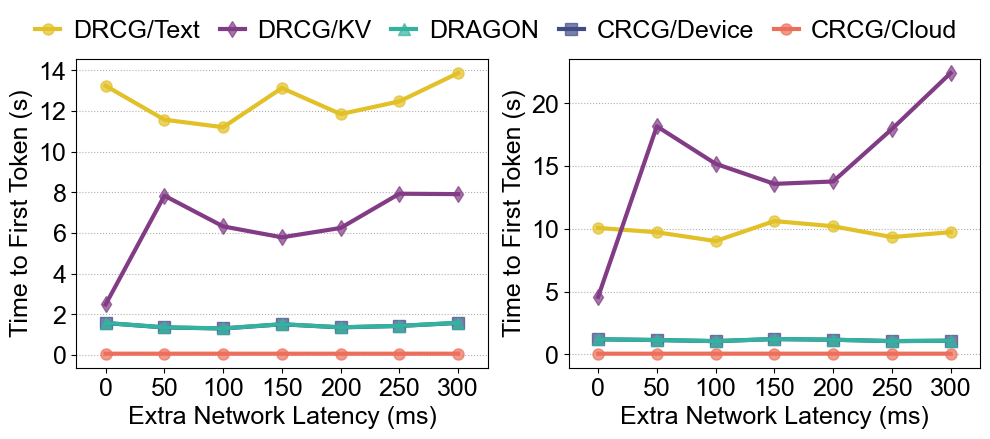

In [66]:
def hex2rgb(hex_color: str):
    hex_color = hex_color.lstrip('#')
    rgb_color = list(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))
    return rgb_color

methods = ["DRCG/Text", "DRCG/KV", "DRAGON", "CRCG/Device", "CRCG/Cloud"]
colors = ['#e2c027', '#813c85', '#33B39F', '#414C87', '#EC6F5C']
marker = ['o', 'd', '^', 's']

font = plt_utils.Font("arial", size=18)
n_docs_list = list(range(2, 17, 2))
marker_alpha = 0.7
plt.figure(figsize=(10, 4), dpi=100)
for i, result in enumerate([result_qwen, result_opt]):
    plt.subplot(1, 2, i + 1)
    for j, method in enumerate(methods):
        stats = [result[group][method] for group in result]
        plt.plot(
            stats, label=method, zorder=3 if method == "DRAGON" else 2, markersize=8, linewidth=3,
            marker=marker[j % len(marker)], color=colors[j % len(colors)],
            markerfacecolor=hex2rgb(colors[j % len(colors)]) + [marker_alpha]
        )
    plt.xticks(np.arange(len(result)), [0, 50, 100, 150, 200, 250, 300], fontproperties=font)
    plt.xlim(-0.5, len(result) - 0.5)
    plt.yticks(fontproperties=font)
    plt.xlabel('Extra Network Latency (ms)', fontproperties=font)
    plt.ylabel('Time to First Token (s)', fontproperties=font)
    plt.grid(axis='y', linestyle=':', zorder=1)
    plt.tight_layout()
plt.legend(
    prop=font, loc='upper right', bbox_to_anchor=(1, 1.2),
    ncol=5, labelspacing=0.2, columnspacing=0.8, 
    frameon=False, handlelength=1, handletextpad=0.5
)
plt.savefig("ttft.pdf", bbox_inches='tight')
plt.show()